[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1_Y1tDASJgpIEAjOK3q0OjXMbU8cNOJKy?usp=sharing)

# Natural Language Processing on Amazon books review dataset

---

### Dhruv Shah, Jenn Hong, Santiago Mazzei, Setu Shah, Victor Floriano

>[Natural Language Processing on Amazon books review dataset](#scrollTo=qUzIn6_QCBg1)

>>>[Dhruv Shah, Jenn Hong, Santiago Mazzei, Setu Shah, Victor Floriano](#scrollTo=qUzIn6_QCBg1)

>>[Data Preprocessing and EDA](#scrollTo=Jo1hXtAmrxoX)

>>>[Column Transformations](#scrollTo=c10MoZ3NU5dJ)

>>>[Dealing With Missing Values](#scrollTo=bSNnEHIbsG9c)

>>[Preliminary Analysis](#scrollTo=_SvtVaUIsxoM)

>>>[Dimension Reduction](#scrollTo=Gu-NYElCtQ7N)

>>>[KMeans Clustering](#scrollTo=BVTPnogmuYX6)

>>>[Hierarchical Clustering](#scrollTo=_ZDq7qk1uHIA)

>>>[Investigating Cluster Characteristics](#scrollTo=94zwzqQ1x8BL)

>>>>[Hierarchical Clustering](#scrollTo=QbM-syIYo8y8)

>>>>[KMeans Clustering](#scrollTo=zGfK6dvWpEHv)

>>[Next Steps](#scrollTo=uAfvbKl8sI5Y)

>>[Text Mining](#scrollTo=jKUXEp-tkNrS)

>>>[Regex](#scrollTo=vlmAftrD2vbp)

>>>[Lemmatizing, Stemming and Tokenizing](#scrollTo=Ofy9joAB20Ma)

>>>[Bag of Words](#scrollTo=7YMOMq_l2-Rq)



In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
# Download the data from Google Drive
!gdown 1GGcWJn9u4efQGt-HMx7UknvvXuhwHAAe

Downloading...
From: https://drive.google.com/uc?id=1GGcWJn9u4efQGt-HMx7UknvvXuhwHAAe
To: /content/random_sample_100.json
100% 55.9M/55.9M [00:00<00:00, 109MB/s]


For this phase of the project, we use a random sample of our dataset (~61,000 rows) as the original file was 20 GB and 27 million rows for each review. We also had a metadata file of 4 GB and ~3 million rows for each unique Amazon product from which we extracted only the important features such as `Price` and `Title`.

In [3]:
# Read JSON file into a dataframe
df = pd.read_json('/content/random_sample_100.json')
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image,vote
0,5,False,"01 23, 2017",A1YTZAZZ1L32RL,0002005263,{'Format:': ' Kindle Edition'},Chuck,Ok reading,Ok,1485129600,NaN,NaN
1,5,True,"08 3, 2014",A3EHZMD24B5BQ0,0002005263,{'Format:': ' Paperback'},Sola49,Good,Five Stars,1407024000,NaN,NaN
2,5,True,"07 9, 2013",A38ZMH9LRCZL3X,0001381733,{'Format:': ' Hardcover'},A. E. Stoff,I purchased it for my new great-granddaughter....,New Book for New Grandchild,1373328000,NaN,NaN
3,5,True,"12 3, 2017",AYMEYAL8G7LJB,0001384198,{'Format:': ' Hardcover'},MARILYN,A very nice replica of the original classic.,Excellent reproduction of the timeless classic.,1512259200,NaN,NaN
4,3,False,"10 4, 2011",A39QEKNEFSJ34Q,0002005263,{'Format:': ' Unknown Binding'},hrladyship,If you're thinking of buying The Sinister Pig ...,And the hero is . . .,1317686400,NaN,NaN


In [4]:
# Download the metadata with genres from Google Drive
!gdown 1oRssCfsz9S_X1r0deuGIqv22VkjWRFT9

Downloading...
From (original): https://drive.google.com/uc?id=1oRssCfsz9S_X1r0deuGIqv22VkjWRFT9
From (redirected): https://drive.google.com/uc?id=1oRssCfsz9S_X1r0deuGIqv22VkjWRFT9&confirm=t&uuid=ae66eadc-b4ea-495a-8e22-57a7a6ef6b87
To: /content/books_meta_short_with_genre.csv
100% 352M/352M [00:04<00:00, 86.2MB/s]


We merge our reviews dataset with the metadata using the `ASIN` column, which refers to the unique identification code used by Amazon for its product listings.

In [5]:
# Read CSV with metadata
meta_data = pd.read_csv('/content/books_meta_short_with_genre.csv')

In [6]:
# Perform a left join to add metadata information (title, price)
# to each book for each book review
merged_df = pd.merge(df, meta_data, on='asin', how='left')

In [7]:
#Remove original dataframes
import gc #garbage collector for deleted dataframes

del df
del meta_data

gc.collect

<function gc.collect(generation=2)>

In [8]:
# Taking a sample of the merged_df because it crashes otherwise

merged_df = merged_df.sample(frac=0.35, random_state=1)

In [9]:
# Check data types and columns
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21385 entries, 3009 to 54996
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   overall          21385 non-null  int64 
 1   verified         21385 non-null  bool  
 2   reviewTime       21385 non-null  object
 3   reviewerID       21385 non-null  object
 4   asin             21385 non-null  object
 5   style            20371 non-null  object
 6   reviewerName     21384 non-null  object
 7   reviewText       21385 non-null  object
 8   summary          21381 non-null  object
 9   unixReviewTime   21385 non-null  int64 
 10  image            47 non-null     object
 11  vote             4039 non-null   object
 12  Unnamed: 0       21385 non-null  int64 
 13  title            21385 non-null  object
 14  price            18313 non-null  object
 15  main_genre       17504 non-null  object
 16  secondary_genre  16321 non-null  object
dtypes: bool(1), int64(3), object

## Data Preprocessing and EDA

---

Upon conducting a preliminary examination of the resulting dataframe, several issues were identified. Originating from JSON files, the `style` column retained its dictionary format, and we encountered multiple instances of null values, formatting inconsistencies, and incorrect data types.

To fix these issues, we corrected formatting and data type discrepancies and adopted a tailored approach for handling missing values.

### Column Transformations

---

In [10]:
# Convert style from dictionary into standard dataframe column
merged_df['style'] = merged_df['style'].apply(lambda x: x['Format:'].strip()\
                                if pd.notnull(x) and 'Format:' in x else x)

merged_df['style'].head()

3009                 Paperback
31323           Kindle Edition
30662                      NaN
39284           Kindle Edition
17217    Mass Market Paperback
Name: style, dtype: object

We also dropped some redundant columns.

In [11]:
# Drop image column since it is beyond of the scope of this project
merged_df.drop(columns='image', inplace=True)

In [12]:
# Dropping 'unnamed 0' column as it is just the index of the meta data column
merged_df.drop(columns='Unnamed: 0', inplace=True)

In [13]:
# Check all unique values for each column, this will help us check the nature of
# each variable and if there are more missing values listed as '?' or 'missing'

#Print unique values for each variable
print("Unique values in 'overall':", merged_df['overall'].unique(), "\n")
print("Unique values in 'verified':", merged_df['verified'].unique(), "\n")
print("Unique values in 'reviewTime':", merged_df['reviewTime'].unique(), "\n")
print("Unique values in 'reviewerID':", merged_df['reviewerID'].unique(), "\n")
print("Unique values in 'asin':", merged_df['asin'].unique(), "\n")
print("Unique values in 'style':", merged_df['style'].unique(), "\n")
print("Unique values in 'reviewerName':", merged_df['reviewerName'].unique(), "\n")
print("Unique values in 'reviewText':", merged_df['reviewText'].unique(), "\n")
print("Unique values in 'summary':", merged_df['summary'].unique(), "\n")
print("Unique values in 'unixReviewTime':", merged_df['unixReviewTime'].unique(), "\n")
print("Unique values in 'vote':", merged_df['vote'].unique(), "\n")

Unique values in 'overall': [5 3 4 2 1] 

Unique values in 'verified': [ True False] 

Unique values in 'reviewTime': ['08 7, 2017' '06 8, 2015' '02 3, 2016' ... '11 9, 2009' '02 12, 1999'
 '09 21, 2009'] 

Unique values in 'reviewerID': ['AV24Y4VN0PEJH' 'A13CGSP0OJ2WJC' 'A30RQOLY8P3V86' ... 'A2NV8Z90MQARTR'
 'A37I0SFN56638P' 'A3FHSO1SKHU378'] 

Unique values in 'asin': ['0002171856' '0007480849' '0007449313' ... '0007481136' '0029254353'
 '0006531555'] 

Unique values in 'style': ['Paperback' 'Kindle Edition' nan 'Mass Market Paperback' 'Hardcover'
 'DVD' 'Board book' 'Loose Leaf' 'Spiral-bound' 'Audio CD'
 'Hardcover-spiral' 'Imitation Leather' 'Leather Bound'
 'Audible Audiobook' 'Library Binding' 'Kindle Edition with Audio/Video'
 'Audio Cassette' 'School & Library Binding' 'Amazon Video' 'MP3 CD'
 'Ring-bound' 'Unknown Binding' 'Vinyl Bound' 'MP3 Music' 'Vinyl'
 'Plastic Comb' 'DVD-ROM' 'Calendar' 'Map' 'DVD Audio' 'Rag Book' 'Poster'] 

Unique values in 'reviewerName': ['Bill Com

In [14]:
# Drop reviewerName, reviewerID, and unixReviewTime (we already have a review time variable)
merged_df.drop(columns=['reviewerName','reviewerID', 'unixReviewTime'], inplace=True)

In [15]:
# Convert reviewTime to datetime (previously an object type)
merged_df['reviewTime'] = pd.to_datetime(merged_df['reviewTime'], format='%m %d, %Y')

In [16]:
# Check distribution of scores
print('Distribution of Book overall ratings:')
merged_df['overall'].value_counts(normalize=True)

Distribution of Book overall ratings:


5    0.627823
4    0.204022
3    0.089829
2    0.042132
1    0.036194
Name: overall, dtype: float64

In [17]:
# Check distribution of book formats
print('Distribution of Book formats')
merged_df['style'].value_counts(normalize=True)

Distribution of Book formats


Kindle Edition                     0.483727
Paperback                          0.230867
Hardcover                          0.186098
Mass Market Paperback              0.064994
Audio CD                           0.010407
Board book                         0.009474
Audible Audiobook                  0.002504
Audio Cassette                     0.001865
Kindle Edition with Audio/Video    0.001620
Library Binding                    0.001522
Imitation Leather                  0.000933
Spiral-bound                       0.000835
Leather Bound                      0.000835
Unknown Binding                    0.000638
MP3 CD                             0.000540
School & Library Binding           0.000491
Amazon Video                       0.000491
DVD                                0.000393
Ring-bound                         0.000344
Hardcover-spiral                   0.000245
MP3 Music                          0.000196
Map                                0.000196
Vinyl                           

### Dealing With Missing Values

---

In [18]:
# Looking at NULL values
merged_df.isna().sum() / len(merged_df) * 100

overall             0.000000
verified            0.000000
reviewTime          0.000000
asin                0.000000
style               4.741641
reviewText          0.000000
summary             0.018705
vote               81.112930
title               0.000000
price              14.365209
main_genre         18.148235
secondary_genre    23.680150
dtype: float64

In [19]:
# Filling in the NULL values, 0 for vote (no one voted that review to be helpful), style as unknown, and price as median as per descriptive statistics

merged_df['vote'] = merged_df['vote'].fillna(0)
merged_df['style'] = merged_df['style'].fillna("unknown")
merged_df['price'] = merged_df['price'].fillna(13.39)

In [20]:
#Filling NULL for main_genre and secondary_genre. Many books did not originally
#had a secondary genre assigned to them, we believe that might not always indicate
#a missing valuer per se. Therefore, for the seondary_genre, missing values will
#stay as null values since in many cases there simply isn't one. For main_genre,
#to avoid mislabelling the book for a review we will just input the book main_genre
#as 'unknown'

merged_df['main_genre'] = merged_df['main_genre'].fillna('unknown')

In [21]:
# Cleaning up the price column which has this one formatting issue and changing the dtype to integer

merged_df['price'] = merged_df['price'].replace(".a-section.a-spacing-mini{margin-bottom:6px!important;margin-top:10px}#actionPanel #availability{font-size:17px!important;font-weight:400!important}#actionPanel #availability p#pa_other_website_text{color:#888!important;margin-top:6px}#actionPanel #merchant-info{font-size:13px;color:#333}#actionPanel #pa_avaliability_message{font-size:12px!important;font-weight:400!important}#actionPanel #pa_avaliability_message a{white-space:normal!important}#actionPanel #pa_avaliability_message span{color:#888!important}#actionPanel #availability-brief #availability+br{display:none}// This is an empty file #actionPanel #bbop-sbbop-container{margin-bottom:0}#actionPanel .buybox-main{padding:0 40px}#actionPanel #priceblock_ourprice_row span.feature img{padding-top:8px!important}#actionPanel #onetimeOption .a-radio-label #priceBadging_feature_div a:not(.a-popover-trigger),#actionPanel #usedOption .a-radio-label #priceBadging_feature_div a:not(.a-popover-trigger){display:none}#actionPanel #pa_feedbackForm_rootmain{text-align:center}.burj #buybox_feature_div #deal #regularBuybox{margin-bottom:14px!important}.burj #hero-quick-promo hr{display:none}#actionPanel #hqp{margin-top:26px}#actionPanel #hqp #amsDetailRight{margin-bottom:18px}#actionPanel #hqp #amsDetailRightWide{margin-bottom:18px}#actionPanel #hqp #hqp-left{margin-bottom:18px}div#hqp-bottom.a-section.burj{margin-bottom:0}.burj #instantOrderUpdate_feature_div", np.NaN)
merged_df['price'] = merged_df['price'].str.replace('$', '').astype(float)

<ipython-input-21-9245d48b8fa3>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  merged_df['price'] = merged_df['price'].str.replace('$', '').astype(float)


In [22]:
# Checking descriptive statistics for Price
merged_df['price'].describe()

count    17545.000000
mean        23.652554
std         55.474282
min          0.010000
25%          8.000000
50%         13.420000
75%         22.810000
max        972.490000
Name: price, dtype: float64

In [23]:
# Dropping null values for review and summary since they have such low %
merged_df.dropna(inplace=True)

In [24]:
# Checking the values of vote to find the mismatched one
merged_df['vote'].unique()

array([0, '2', '4', '19', '3', '7', '5', '15', '12', '13', '36', '11',
       '18', '6', '14', '8', '96', '41', '26', '21', '33', '9', '42',
       '89', '24', '22', '20', '16', '299', '64', '35', '25', '28', '69',
       '40', '38', '30', '23', '10', '48', '60', '429', '212', '17', '31',
       '27', '135', '43', '32', '68', '123', '50', '77', '34', '88', '49',
       '92', '45', '52', '29', '37', '119', '199', '82', '44', '84', '95',
       '80', '46', '104', '47', '87', '55', '108', '58', '70', '39',
       '190', '143', '201', '54', '66', '102', '67', '105', '312', '61',
       '101', '133', '132', '51', '606', '56', '116', '548', '81', '93',
       '62', '231', '94', '112'], dtype=object)

In [25]:
# Changing the dtype of verified to 0 and 1, changing the dtype of vote to int
merged_df['verified'] = merged_df['verified'].astype(int)
merged_df['vote'] = merged_df['vote'].replace('6,547', '6547').astype(int)

In [26]:
# Creating and adding a new column that has the number of reviews for each book

count_df = pd.DataFrame(merged_df['asin'].value_counts())
count_df = count_df.reset_index()
count_df.columns = ['asin', 'total_review_count']

merged_df = pd.merge(merged_df, count_df, on='asin', how='left')

In [27]:
# Adding columns for year, month, date so we can use the reviewtime column for clustering

merged_df['year'] = merged_df['reviewTime'].dt.year
merged_df['day_of_week'] = merged_df['reviewTime'].dt.dayofweek
merged_df['month'] = merged_df['reviewTime'].dt.month
merged_df

,overall,verified,reviewTime,asin,style,reviewText,summary,vote,title,price,main_genre,secondary_genre,total_review_count,year,day_of_week,month
0,5,1,2017-08-07,0002171856,Paperback,This is the best Survival guide out there and ...,Best Survival Guide Ever!,0,The Sas Survival Handbook,9.45,History,Military,40,2017,0,8
1,5,1,2016-02-03,0007449313,unknown,I have loved this book from the first time I r...,I have loved this book from the first time I r...,0,Pride &amp; Prejudice (Collins Classics),24.99,Self-Help,Relationships,80,2016,2,2
2,5,0,2013-09-11,0007176236,Mass Market Paperback,I love this fun book. Janet Evanovich's books...,Huge fan!,0,METRO GIRL (Alex Barnaby),24.98,Literature & Fiction,Genre Fiction,17,2013,2,9
3,4,1,2017-04-07,0002255863,Paperback,"Reading through, it almost feels like what one...",it almost feels like what one would imagine th...,2,The God of Small Things,5.49,Literature & Fiction,Contemporary,20,2017,4,4
4,4,1,2012-12-22,0002171856,Paperback,I like it. It is very informative and one cou...,Awesome,0,The Sas Survival Handbook,9.45,History,Military,40,2012,5,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12905,5,1,2010-06-13,002907052X,Paperback,"Wow, what a book. I didn't realize there was t...",Angel Dictionary,0,A Dictionary of Angels: Including the Fallen A...,19.48,Christian Books & Bibles,Theology,8,2010,6,6
12906,1,0,2009-09-21,0007181604,Mass Market Paperback,"I've read a lot of Crichton's novels, and I no...",Crichton's worst,3,State of Fear,12.95,Literature & Fiction,Genre Fiction,50,2009,0,9
12907,4,1,2017-02-09,0007177437,Kindle Edition,Excellent read. I couldn't put it down.,Four Stars,0,PEOPLE OF THE BOOK,15.99,Literature & Fiction,Action & Adventure,26,2017,3,2
12908,4,0,2002-09-21,0060082194,Mass Market Paperback,"Jackie Burke is caught with $50,000.00 and som...",RUM PUNCH HAS SOME PUNCH!!!,0,Rum Punch,25.13,Literature &amp; Fiction,Literary,3,2002,5,9


To conclude our preprocessing stage, we carefully selected the variables most relevant for our subsequent clustering analysis:

* `overall`: the review score (1 to 5)

* `verified`: whether the review was verified or not (binary)

* `vote`: how many upvotes did each review received

* `price`: the price of the book being reviewed

* `total_review_count`: the total number of reviews for the book being reviewed

* `year`: year of the review

* `day_of_week`: day of the week for the review

* `month`: month of the review


In [28]:
# Pulling out relevant variables for clustering

clustering_df = merged_df[['overall', 'verified', 'vote', 'price', 'total_review_count', 'year', 'day_of_week', 'month']]

In [29]:
clustering_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12910 entries, 0 to 12909
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   overall             12910 non-null  int64  
 1   verified            12910 non-null  int64  
 2   vote                12910 non-null  int64  
 3   price               12910 non-null  float64
 4   total_review_count  12910 non-null  int64  
 5   year                12910 non-null  int64  
 6   day_of_week         12910 non-null  int64  
 7   month               12910 non-null  int64  
dtypes: float64(1), int64(7)
memory usage: 907.7 KB


## Preliminary Analysis

---

After completing the initial preprocessing, we standardized the data to prepare it for the next steps.

Post-standardization, we applied dimension reduction (PCA) to the dataset and assessed the cumulative explained variance by each principal component. Our analysis revealed that retaining ~94% of explained variance required 6 out of 7 components.

Given the minimal number of features in our dataset, we deemed the loss in interpretability from PCA unnecessary. Consequently, we decided to continue with our analysis using only the standardized data, bypassing PCA to preserve interpretability for our clustering methods.

### Dimension Reduction

---


In [30]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
normalized_data = sc.fit_transform(clustering_df)

df_normalized = pd.DataFrame(normalized_data, columns=clustering_df.columns)

df_normalized

,overall,verified,vote,price,total_review_count,year,day_of_week,month
0,0.640448,0.675978,-0.159664,-0.273610,-0.337093,1.028750,-1.473584,0.497091
1,0.640448,0.675978,-0.159664,0.000377,-0.131104,0.796346,-0.466678,-1.223556
2,0.640448,-1.479338,-0.159664,0.000201,-0.455536,0.099136,-0.466678,0.783865
3,-0.314970,0.675978,0.006460,-0.343430,-0.440087,1.028750,0.540227,-0.650007
4,-0.314970,0.675978,-0.159664,-0.273610,-0.337093,-0.133267,1.043680,1.644189
...,...,...,...,...,...,...,...,...
12905,0.640448,0.675978,-0.159664,-0.096770,-0.501884,-0.598074,1.547133,-0.076458
12906,-3.181223,-1.479338,0.089522,-0.211902,-0.285596,-0.830478,-1.473584,0.783865
12907,-0.314970,0.675978,-0.159664,-0.158303,-0.409189,1.028750,0.036774,-1.223556
12908,-0.314970,-1.479338,-0.159664,0.002845,-0.527632,-2.457301,1.043680,0.783865


In [31]:
# Principal Component Analysis
from sklearn.decomposition import PCA
import plotly.express as px
import matplotlib.pyplot as plt

# Fit PCA model on dataset
model = PCA()
model.fit(df_normalized)
transformed_data = model.transform(df_normalized)

pca_data = pd.DataFrame(transformed_data)

column_names = []
for k in range(1, 9):
  column_names.append("PCA " + str(k))

pca_data.columns = column_names

# Plot variance per Principal Component
cumulative_var = np.cumsum(model.explained_variance_ratio_*100)
px.line(cumulative_var, title='Variance Captured by Each Principal Component', labels={'value': 'Cumulative Variance', 'index':'Principal Component'})

KeyboardInterrupt: 

### KMeans Clustering

---

First, we tried KMeans clustering and used elbow plot to determine optimal number of clusters. We also used silhouette plots to assess the shape of our clusters and if they were distinct from each other.

In [ ]:
# KMeans Clustering
from sklearn.cluster import KMeans

num_clusters = 5
kmeans_df = clustering_df
kmeans_result = KMeans(num_clusters,init='random', n_init = 'auto', random_state = 0).fit(df_normalized)
kmeans_df['cluster_labels'] = kmeans_result.labels_

We did not find an obvious optimal k from the eblow plot below, but we settled on k = 5 due to the slight kink we observe. We also based this decision on the balancing between the need to minimize number of clusters while also reducing overall distortion. According to our preliminary analysis, k = 5 helps us achieve these divergent goals.

In [ ]:
# Plotting elbow plot to visualize optimal clusters
distortions = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init = 'auto', random_state = 2)
    kmeans.fit(df_normalized)
    distortions.append(kmeans.inertia_)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.suptitle('Elbow Method for Optimal K', y = 0.93)
plt.grid(False)
plt.show();

The silhouette plot supports our decision to use k=5 as the optimal number of clusters. The silhouettes are of similar size with a averege silhouette score threshold of approximately 0.22.

In [ ]:
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(3, 3, figsize=(15,8))

for i in [2, 3, 4, 5, 6, 7, 8, 9, 10]:

    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 3)

    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df_normalized)

We do not observe any clear visual patterns between clusters from the pairplots below.

In [ ]:
# Plotting pair plots with KMeans clusters
sns.pairplot(kmeans_df, hue='cluster_labels')

### Hierarchical Clustering

---

Next, we tried Hierarchical clustering on our dataset. We utilized Silhouette scores to assess our clusters. We tried different methods and decided to move forward with `Ward` as it gave us the best results.

In [ ]:
# Hierarchical Clustering
from scipy.cluster.hierarchy import linkage, fcluster

Z = linkage(df_normalized, 'ward')
num_clusters = 5
clustering_df.drop('cluster_labels', axis=1)
clustering_df['cluster_labels'] = fcluster(Z, num_clusters, criterion='maxclust')

From the silhouette scores, the optimal number of clusters for hierarchical clustering was 6 clusters.

However, given we had used 5 clusters for KMeans, and the difference in silhouette score was not substantial between 5 and 6 clusters, so we decided to stick to 5 clusters to stay consistent.

Therefore, both KMeans and hierarchical clustering ended up yielding the same 5 clusters, showing that neither method was superior over the other.

In [ ]:
# Plotting Silhouette Scores
from sklearn.metrics import silhouette_score

s_scores = []

for k in range(2, 12):
  clust_labels = fcluster(Z, k, criterion = 'maxclust')
  s_scores.append(silhouette_score(df_normalized, clust_labels))

s_scores_df = pd.DataFrame(data={'cluster_no': [2,3,4,5,6,7,8,9,10,11], 's_scores':s_scores})
sns.lineplot(s_scores_df, x="cluster_no", y="s_scores")

We take a look at the pairwise pairplots by cluster to find visualize any patterns. We observe some variation between clusters based on the `Price` and `Total_Review_Count` variables.

In [ ]:
# Plotting pair plots by cluster
sns.pairplot(clustering_df, hue='cluster_labels')

### Investigating Cluster Characteristics

---

We investigated cluster characteristics from both hierarchical and KMeans methods. From our preliminary analysis, we found that cluster characteristics across both methods were quite similar.

Our analysis also revealed different characteristics across the five clusters, offering insights into reader engagement, credibility of reviews, and book pricing.

Overall, the clusters show diverse behaviors, from high engagement and casual reviewing in Cluster 1 to the high credibility and positive reception in Clusters 3 and 4. Cluster 5 highlights a niche engaged segment of readers for expensive books. This analysis shows the different nature of book reviews.

In [ ]:
# Appending the cluster labels to our original dataframe

merged_df['hier_cluster_labels'] = clustering_df['cluster_labels']
merged_df['k_means_cluster_labels'] = kmeans_df['cluster_labels']

#### Hierarchical Clustering

---

In [ ]:
# Investigating the hierarchical clusters

# Cluster 1
merged_df[merged_df['hier_cluster_labels'] == 1].describe()

Taking a look into Cluster 1, above the main insights:

* There are 16 entries in this cluster.
* The `vote` variable has a high mean value of approximately 324, which means that this cluster may represent reviews that received a lot of votes.
* The `overall` rating averages to 4, with a standard deviation of approximately 1.15, which suggests moderate variation in the ratings within this cluster.
* The `verified` mean is close to 0.43, suggesting that less than half of the reviews in this cluster come from verified purchases.
* The `price` has a wide range, with a mean of 14.95 and a standard deviation of 13.01, indicating varied pricing for the books in this cluster.
* The `total review count` is also a little bit spread out, with a mean of 102.38 and a high maximum value, suggesting some books have a very high review count.
* The `year` data suggests that the books in this cluster were reviewed around the year 2009 on average, with reviews spanning from the year 2000 to 2015.
* The `day of week` and `month` might represent the time when the reviews were most frequently posted, with averages suggesting that there isn't a strong bias toward any specific day of the week or month.

In [ ]:
# Cluster 2
merged_df[merged_df['hier_cluster_labels'] == 2].describe()

Taking a look into Cluster 2, above the main insights:

* This cluster contains a large number of entries of 6,296 reviews.
* The average rating `overall` for this cluster is approximately 3.77, which suggests that the books in this cluster are rated as good but not exceptional.
* A low `verified` purchase mean (around 0.22) indicates that only about 22% of the reviews are from verified purchases, which could impact the reliability of the reviews.
* The mean number of votes `(vote)` is relatively low at 3.65, but with a maximum of 154, showing that some reviews do have a lot of attention.
* The average price of books `(price)` is about 19.36, with a broad range, indicating a diversity in the book prices within this cluster.
* There is a wide range in the total number of reviews `(total review count)`, with some books getting up to 632 reviews, suggesting varying degrees of discussion among the books.
* The reviews span from 1997 to 2018, with most reviews written around 2010 `(year)`, showing a broad temporal distribution.
* The distribution of reviews over the days of the week and months`(day of week and month)` is quite even, with no particular day or month standing out.

In [ ]:
# Cluster 3
merged_df[merged_df['hier_cluster_labels'] == 3].describe()

Taking a look into Cluster 3, above the main insights:

* Cluster '3' is also large, with 9,235 reviews.
* The books in this cluster have a high average rating of 4.65 (`overall`), indicating that they are generally well-regarded.
* Every review in this cluster is from a `verified` purchase (verified mean is 1.0), suggesting a higher reliability of the reviews.
* The average number of votes (`vote`) is quite low at 0.31, which could mean these books are less interesting or do not have as much active engagement in voting as the other clusters.
* The books are moderately `priced` on average (price mean of 18.81), with some books priced as high as 245.
* A relatively high average total review count (`total review count` mean of 48.58) suggests these books are frequently discussed, with a range that indicates some titles are more popular than others.
* The review years (`year`) range from 2004 to 2018, with an average around 2014, suggesting these books maintain ongoing interest.
* As with cluster '2', the review timing is spread evenly across days and `months`, with no specific trends in the timing of reviews (`day of week` and month averages are 2.92 and 6.49 respectively).

In [ ]:
# Cluster 4
merged_df[merged_df['hier_cluster_labels'] == 4].describe()

Taking a look into Cluster 4, above the main insights:

* Cluster 4 contains 1,905 reviews.
* The average rating (`overall`) is quite high at approximately 4.57, indicating that the books in this cluster are generally well-received.
* Most of reviews are from `verified` purchases, with a mean of 0.79685, suggesting high credibility.
* The mean number of votes (`vote`) is a little bit low at around 0.32, suggesting that these books don't tend to generate a lot of voting activity.
* The average price (`price`) is moderate at about 30.23, but there is considerable variability as indicated by the standard deviation of approximately 33.82.
* The total `review` count has a high mean of 638.33, suggesting that the books in this cluster attract a lot of reviews compared to others.
* The reviews cover a wide range of `years`, from 1998 to 2018, with most of them being around 2013, indicating sustained interest over a long period.
* Reviews are evenly distributed throughout the `week` and `year`, with no significant bias towards any particular day or month as the other clusters.

In [ ]:
# Cluster 5
merged_df[merged_df['hier_cluster_labels'] == 5].describe()

Taking a look into Cluster 5, above the main insights:

* Cluster 5 comprises 89 reviews.
* The books in this cluster have an average rating (`overall`) of around 4.39, which is quite favorable.
* Nearly all the reviews come from `verified` purchases, as the verified mean is 0.752809, enhancing the trustworthiness of the ratings.
* The average number of votes (`vote`) is around 4.20, which is higher than in cluster '4', indicating more engagement in terms of voting.
* The standout feature of this cluster is the high average price (`price`) of approximately 690.15, suggesting that this cluster includes some of the most expensive books in the database.
* The `total review count` for this cluster is moderate, with an average of about 11.54, though there is significant variation as indicated by the standard deviation.
* The `year` range for reviews is from 1999 to 2018, with the average review year being around 2013, showing that these high-priced books have been consistently reviewed over the years.
* The distribution of reviews across days and months is relatively even, with a slight tendency towards reviews being written later in the year (average month is around 6.35).

#### KMeans Clustering

---

Below are the descriptive statistics from the KMeans clusters. However, we notice that cluster characteristics are similar to our results from hierarchical clustering above.

In [ ]:
# Moving on to KMeans

# Cluster 1
merged_df[merged_df['k_means_cluster_labels'] == 1].describe()

In [ ]:
# Cluster 2
merged_df[merged_df['k_means_cluster_labels'] == 2].describe()

In [ ]:
# Cluster 3
merged_df[merged_df['k_means_cluster_labels'] == 3].describe()

In [ ]:
# Cluster 4
merged_df[merged_df['k_means_cluster_labels'] == 4].describe()

## Next Steps

---

After clustering, we are curious to implement text mining and sentiment analysis to better understand the nature of positive and negative reviews for each book, giving us some summary statistics on sentiment for each book.

It also can give a quick overview of the review, like a form of summarization, to give other users a snapshot of what sentiment a review may have without having to read the whole review. This will help streamline user experience and improve quality of time spent on site.

## Text Mining

### Regex, Lemmatizing and Tokenizing


In [32]:
reviews_df = merged_df[['reviewText']] # Creating a new df which only includes the reviewText

In [33]:
reviews_df

,reviewText
0,This is the best Survival guide out there and ...
1,I have loved this book from the first time I r...
2,I love this fun book. Janet Evanovich's books...
3,"Reading through, it almost feels like what one..."
4,I like it. It is very informative and one cou...
...,...
12905,"Wow, what a book. I didn't realize there was t..."
12906,"I've read a lot of Crichton's novels, and I no..."
12907,Excellent read. I couldn't put it down.
12908,"Jackie Burke is caught with $50,000.00 and som..."


In [34]:
reviews_df = pd.DataFrame(reviews_df.reviewText.str.lower()) # Lower Case
reviews_df = pd.DataFrame(reviews_df['reviewText'].str.findall(r'\b[a-zA-Z\d]+\b')) # Keeping only english words (numbers included)
reviews_df['reviewText'] = reviews_df['reviewText'].apply(lambda x: ' '.join(x))

In [35]:
reviews_df

,reviewText
0,this is the best survival guide out there and ...
1,i have loved this book from the first time i r...
2,i love this fun book janet evanovich s books a...
3,reading through it almost feels like what one ...
4,i like it it is very informative and one could...
...,...
12905,wow what a book i didn t realize there was tha...
12906,i ve read a lot of crichton s novels and i now...
12907,excellent read i couldn t put it down
12908,jackie burke is caught with 50 000 00 and some...


In [36]:
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [37]:
def process_text(document):
    # Tokenizing the document
    tokens = word_tokenize(document)
    # Removing stop words
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Applying lemmatization first
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    return lemmatized_tokens

In [ ]:
# # Replacing positive words with a replacement word for better results in sentiment analysis later on
# positive_words = ['like', 'love', 'adore', 'enjoy', 'happy', 'excited',
#                   'amazing', 'awesome', 'fantastic', 'great', 'wonderful',
#                   'delightful', 'pleasure', 'blissful', 'cheerful', 'ecstatic',
#                   'excellent', 'fabulous', 'glorious', 'joyful', 'magnificent',
#                   'vibrant', 'delicious', 'grateful', 'satisfying', 'thrilled',
#                   'fortunate', 'beautiful', 'charming', 'brilliant', 'radiant',
#                   'energetic', 'lively', 'euphoric', 'celebratory', 'uplifting',
#                   'inspiring', 'fulfilled', 'content', 'triumphant', 'graceful',
#                   'tranquil', 'serene', 'optimistic', 'blessed', 'jubilant',
#                   'exhilarated', 'sunny', 'affectionate', 'victorious', 'glowing',
#                   'wholesome', 'heartwarming', 'sensational', 'gleeful', 'zestful', 'best']

# replacement_word = 'positive'  # The word to replace positive words with

# # Create a regular expression pattern to match any positive word
# pattern = '|'.join(r'\b{}\b'.format(word) for word in positive_words)

# # Replace positive words with the replacement word
# reviews_df['reviewText'] = reviews_df['reviewText'].str.replace(pattern, replacement_word)

In [ ]:
# # Replacing negative words with a replacement word for better results in sentiment analysis later on
# negative_words = ['dislike', 'hate', 'despise', 'disgust', 'sad', 'depressed',
#                   'frustrated', 'angry', 'annoyed', 'irritated', 'worried',
#                   'miserable', 'unhappy', 'upset', 'regret', 'disappoint',
#                   'terrible', 'awful', 'horrible', 'bad', 'poor',
#                   'dreadful', 'painful', 'unpleasant', 'distressed', 'anguished',
#                   'stressed', 'gloomy', 'mournful', 'heartbroken', 'sorrowful',
#                   'desperate', 'grief-stricken', 'hopeless', 'despairing', 'bleak',
#                   'lonely', 'isolated', 'desolate', 'unfortunate', 'tragic',
#                   'dismal', 'grim', 'melancholy', 'wretched', 'disheartened',
#                   'discouraged', 'demoralized', 'futile', 'forlorn', 'defeated']

# replacement_word = 'negative'  # The word to replace negative words with

# # Create a regular expression pattern to match any negative word
# pattern = '|'.join(r'\b{}\b'.format(word) for word in negative_words)

# # Replace negative words with the replacement word
# reviews_df['reviewText'] = reviews_df['reviewText'].str.replace(pattern, replacement_word)


In [ ]:
# print(' '.join(process_text(reviews_df['reviewText'].loc[0])))

### Tokenization

In [38]:
# Tokenizing reviews

tokenized_reviews = [process_text(review) for review in reviews_df['reviewText']]

In [39]:
len(tokenized_reviews) #each list in the list of lists in the list of tokens for a review

12910

In [40]:
#Check if any reviews were converted to empty lists due to all tokens being stop_words
empty_lists_count = sum(1 for review in tokenized_reviews if len(review) == 0)

print(f'There are {empty_lists_count} empty tokenized reviews')

There are 14 empty tokenized reviews


In [41]:
reviews_df["tokenized"] = tokenized_reviews

## Sentiment Analysis Trial 1 - Word2Vec:

To evaluate different model we calculated the sentiment using two test reviews, one negative and one positive. They were as follows:

* test_positive: "great book loved it, very exciting, perfect"
* test_negative: "bad book hated it, very boring, horrible"

* Model used: Word2Vec
* vector_size: [50, 100, 200]
* window: [4, 5, 6]
* min_count: [1, 2, 3]

* Ideal positiove and ideal negative were custom lists created by us. The full list can be found in the code below

In [89]:
from gensim.models import Word2Vec

In [90]:
#Defining the two extremes, ideal_pos and ideal_neg. Custom made

#maybe try more lists - look into online resources
ideal_pos = ["positive", "fantastic", "love", "amazing", "nice", "gorgeous", "like", "good", "favorite", "best", 'great', 'wonder', 'delight', 'pleasure', 'grateful', 'satisfying', 'thrilled', 'fortunate', 'beautiful', 'charming', 'brilliant', 'radiant', 'inspiring', 'fulfilled', 'content', 'triumphant', 'graceful',  'wholesome', 'heartwarming', 'sensational', 'gleeful', 'zestful', "enjoyable", "abundance", "amaze", "enjoy", "great", "excellent", "stun", "yes", "recommend","beautiful", "adore", "appreciate", "cherish", "happy", "nice", "interesting", "captivating", "want", "refreshing", "fun", "brilliant", "satisfying", "warm", "sun", "fan"]
ideal_neg = ["negative", "boring", "terrible", "bad", "hate", "disappointed", "sucks", 'dislike', 'despise', 'disgust', 'sad', 'depressed', 'frustrated', 'angry', 'annoyed', 'irritate', 'worry', 'miserable', 'unhappy', 'upset', 'regret', 'disappoint', 'terrible', 'awful', 'horrible', 'bad', 'poor', 'dreadful', 'painful', 'unpleasant', 'distressed', 'anguished', 'stressed', 'gloomy', 'mournful', 'heartbroken', 'sorrowful', 'desperate', 'grief-stricken', 'hopeless', "no", 'despairing', 'bleak', 'lonely', 'isolated', 'desolate', 'unfortunate', 'tragic', 'dismal', 'grim', 'melancholy', 'wretched', 'disheartened', 'discouraged', 'demoralized', 'futile', 'forlorn', 'defeated']


#Defining the sentiment score function
def sentiment(review):
    #Check if review is not an empty list (could happen if all words are stop words)
    if not review:
        return np.nan
    else:
        return model_word2vec.n_similarity(review, ideal_pos) - model_word2vec.n_similarity(review, ideal_neg)

In [ ]:
# Pulling out some test sentences/reviews just to test the model
test_sentence_pos = process_text("great book loved it, very exciting, perfect") #might want to add real reviews at some point
test_sentence_neg = process_text("bad book hated it, very boring, horrible")


In [96]:
#Iterate over multipel paraneters for Word2Vec, test the model against test
#positive and test negative sentences, stores values in a list of lists, pick the
#best model

#Initialize a score list to store the results of each iteration of Word2Vec
#Order of results in lists inside list of lists will follow the format:
#[pos_test_score, neg_test_score, vector_size, window, min_count]
scores_word2vec = []

#Create list for test vector sizes
vector_size_list = [50, 100, 200]

#Create list for test window values
window_list = [4, 5, 6]

#Create list for test min_count values
min_count_list = [1, 2, 3]

#Iterate over all values
for vector_size in vector_size_list:
  for window in window_list:
    for min_count in min_count_list:

      model_word2vec = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=1, workers=2)

      model_word2vec = model_word2vec.wv #after this step we have trained model with the mappings between words and their vectors

      #Use current iteration model get scores
      positive_review_test_score = sentiment(test_sentence_pos)
      negative_review_test_score = sentiment(test_sentence_neg)

      #Add current iteration scores to score list
      scores_word2vec += [[positive_review_test_score, negative_review_test_score, vector_size, window, min_count]]


In [97]:
#Convert results into DataFrame format
scores_word2vec_df = pd.DataFrame(scores_word2vec,
                  columns=['positive_review_test_score',\
                           'negative_review_test_score', 'vector_size',\
                           'window', 'min_count'])

scores_word2vec_df

,positive_review_test_score,negative_review_test_score,vector_size,window,min_count
0,0.091436,-0.019937,50,4,1
1,0.100386,-0.018853,50,4,2
2,0.100309,-0.015049,50,4,3
3,0.101253,-0.014063,50,5,1
4,0.096841,-0.016526,50,5,2
5,0.097673,-0.017396,50,5,3
6,0.092966,-0.006553,50,6,1
7,0.099979,-0.012108,50,6,2
8,0.089399,-0.012706,50,6,3
9,0.097835,-0.013387,100,4,1


##Select Best Model before moving on!! (won't work. yet)

In [70]:
reviews_df['sentiment_score'] = reviews_df['tokenized'].apply(lambda x: sentiment(x))

<Axes: >

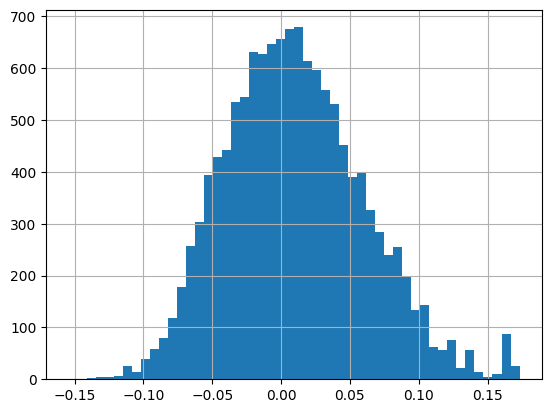

In [72]:
#storing it in a df
reviews_df['sentiment_score'].hist(bins=50)

In [74]:
#Adding score back to original df
merged_df['sentiment_score'] = reviews_df['sentiment_score']

In [75]:
#Checking sentiment score for overall ratings
merged_df.groupby('overall')['sentiment_score'].mean()

overall
1   -0.011047
2   -0.010620
3   -0.003829
4    0.002802
5    0.017533
Name: sentiment_score, dtype: float64

In [76]:
#Checking sentiment score for verified or non-verified users
merged_df.groupby('verified')['sentiment_score'].mean()

verified
0   -0.013984
1    0.021247
Name: sentiment_score, dtype: float64

In [78]:
merged_df.groupby('main_genre')['sentiment_score'].mean().sort_values(ascending=False)

main_genre
Education & Teaching                              0.071292
Computers & Technology                            0.032243
Teen & Young Adult                                0.025326
Children's Books                                  0.022518
Mystery, Thriller &amp; Suspense                  0.020643
Comics & Graphic Novels                           0.019930
Mystery, Thriller & Suspense                      0.019420
Science Fiction & Fantasy                         0.014203
Literature & Fiction                              0.014168
Humor & Entertainment                             0.012375
Parenting &amp; Relationships                     0.011089
Comics &amp; Graphic Novels                       0.010982
Lesbian, Gay, Bisexual & Transgender Books        0.009542
Cookbooks, Food & Wine                            0.008844
Christian Books & Bibles                          0.008649
Literature &amp; Fiction                          0.008415
Humor &amp; Entertainment                    

In [ ]:
#Im not sure I undertand this one
merged_df.groupby('vote')['sentiment_score'].mean() #.sort_values(ascending=False)

vote
84     0.041325
0      0.025978
73     0.020589
80     0.016253
94     0.007346
         ...   
108   -0.120900
254   -0.124593
148   -0.124889
116   -0.134684
95    -0.141752
Name: sentiment_score, Length: 113, dtype: float32

### Archive/Old/Unused code

In [ ]:
# from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# cv = CountVectorizer()

# cv.fit(reviews_df.reviewText)

# print('number of `tokens`', len(cv.vocabulary_))
# cv.vocabulary_

In [ ]:
# dtm = cv.transform(reviews_df.reviewText)
# bow = pd.DataFrame(dtm.toarray(), columns=cv.get_feature_names_out())
# bow

In [ ]:
# Pulling out the embeddings to use as features for logistic regression

import nltk
nltk.download('punkt')

# def get_word_embedding(word, model):
#     if word in model.key_to_index:
#         return model[word]
#     else:
#         return np.zeros(model.vector_size)


# embeddings = []
# for review in tokenized_reviews:
#   review_embeddings = [get_word_embedding(word, model_word2vec) for word in review ]
#   review_embedding = np.mean(review_embeddings if len(review_embeddings) >0 else [np.zeros(model_word2vec.vector_size)], axis=0)
#   embeddings = embeddings + [review_embedding]

# embeddings = np.array(embeddings)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# embeddings.shape

(17541, 100)

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# import sklearn
# from sklearn.metrics import confusion_matrix, classification_report, f1_score

# X_train, X_test, y_train, y_test = train_test_split(embeddings, reviews_df['reviewText'], test_size=0.2, random_state=42)

# # Train the model
# model_word2vec_classification = LogisticRegression()
# model_word2vec_classification.fit(X_train, y_train)

# # Predict on the test data
# y_pred2 = model_word2vec_classification.predict(X_test)

# # Evaluate the model using 'weighted' average for multiclass classification
# f1_score_weighted = f1_score(y_test, y_pred2, average='weighted')
# print(f"f1_score (weighted): {f1_score_weighted}")

# # Classification Report
# print(classification_report(y_test, y_pred2))
